In [ ]:
from pathlib import Path

import numpy as np
from moviepy.editor import AudioFileClip, VideoClip
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from scipy.fft import fft

ROOT = Path("..")

In [80]:
# ---------- CONFIG ----------
AUDIO_PATH = str(ROOT / "data/sample2.mp3")
OUTPUT_PATH = str(ROOT / "output/sample.mp4")
IMG_PATH = str(ROOT / "data/sample2.jpg")
FPS = 30
# -----------------------------

In [81]:
def load_audio(path):

    # Load the audio
    audio_clip = AudioFileClip(path)

    # Convert audio to a numpy array (mono)
    # fps here is only for analysis, not video fps
    analysis_fps = 44100

    # Manually collect chunks into a list, then concatenate
    chunks = list(
        audio_clip.iter_chunks(
            fps=analysis_fps,
            quantize=True,  # get int16-ish PCM
            nbytes=2,
            chunksize=1024
        )
    )

    return np.concatenate(chunks, axis=0).astype(np.float32)


def normalize(audio_array):
    # Convert to mono if stereo
    if audio_array.ndim == 2:
        mono = audio_array.mean(axis=1)
    else:
        mono = audio_array

    min = mono.min()
    max = mono.max()
    return (mono - min)/(max - min + 1e-7)

In [127]:
def get_parameters(x, bands):

    X = fft(x)
    X = np.abs(X)

    sample_count = X.shape[0]
    window = sample_count // bands

    E_arr = []
    start = 0
    while start < sample_count - 1:

        band = X[start:start+window]

        E = (band**2).sum()
        E_arr.append(E)

        start += window

    E_arr = np.array(E_arr)
    return E_arr / (E_arr.sum() + 1e-7)


def get_xy(params: np.ndarray, A, B):

    u = np.linspace(0, 2*np.pi, 1000)
    u = u.reshape(1, u.shape[0])

    k = np.arange(0, params.shape[0])
    k = k.reshape(k.shape[0], 1)

    theta = k*u
    x = np.cos(theta)
    y = np.sin(theta)

    params = params.reshape(x.shape[0], 1)

    x = (A*x*params).sum(axis=0)
    y = (B*y*params).sum(axis=0)

    return x, y

In [128]:
def plot_harmonic(seed):

    rng = np.random.default_rng(seed=seed)

    params = rng.uniform(low=0, high=1., size=8)
    print(params)

    x, y = get_xy(params=params, A=1, B=1)
    plt.plot(x, y)

In [129]:
# plot_harmonic(seed=None)

In [132]:
def viz_audio(audio_path, image_path, video_output, window=16, blur=True, bands=8, color="black"):

    audio_clip = AudioFileClip(audio_path)
    # audio_clip = audio_clip.subclip(0, 5)
    duration = audio_clip.duration

    mono = load_audio(audio_path)
    mono = normalize(mono)
    mono_padded = np.pad(mono, pad_width=(0, int(window)))

    base_img = Image.open(image_path)
    if blur:
        base_img = base_img.filter(ImageFilter.GaussianBlur())

    height, width = np.array(base_img).shape[0:2]
    dpi = 100

    fig = plt.figure()
    fig = plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1])

    # idx = 0
    # segment = mono[idx:idx+window]

    # params = get_parameters(segment, bands=bands)
    # x, y = get_xy(params, A=1., B=1.)

    # plt.plot(x, y)

    # Function to generate each video frame
    def make_frame(t):

        ax.cla()
        # ax.imshow(base_img)
        ax.axis("off")

        idx = int(t/duration*(mono.shape[0]-1))
        segment = mono_padded[idx:idx+window]

        params = get_parameters(segment, bands=bands)
        
        A = B = 1.0

        x, y = get_xy(params, A=A, B=B)

        # ax.plot(np.arange(0, len(y)), y, color=color)
        ax.plot(x, y, color=color)

        # Render the figure
        fig.tight_layout()
        fig.canvas.draw()

        # RGBA buffer as (H, W, 4)
        buf = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        w, h = fig.canvas.get_width_height()
        frame = buf.reshape(h, w, 4)[..., :3]

        return frame

    # Create video clip
    video_clip = VideoClip(make_frame, duration=duration)
    video_clip = video_clip.set_audio(audio_clip)

    # Export
    video_clip.write_videofile(
        video_output,
        fps=FPS,
        codec="libx264",
        audio_codec="aac"
    )

Moviepy - Building video ../output/sample.mp4.
MoviePy - Writing audio in sampleTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ../output/sample.mp4



Moviepy - Done !
Moviepy - video ready ../output/sample.mp4


<Figure size 640x480 with 0 Axes>

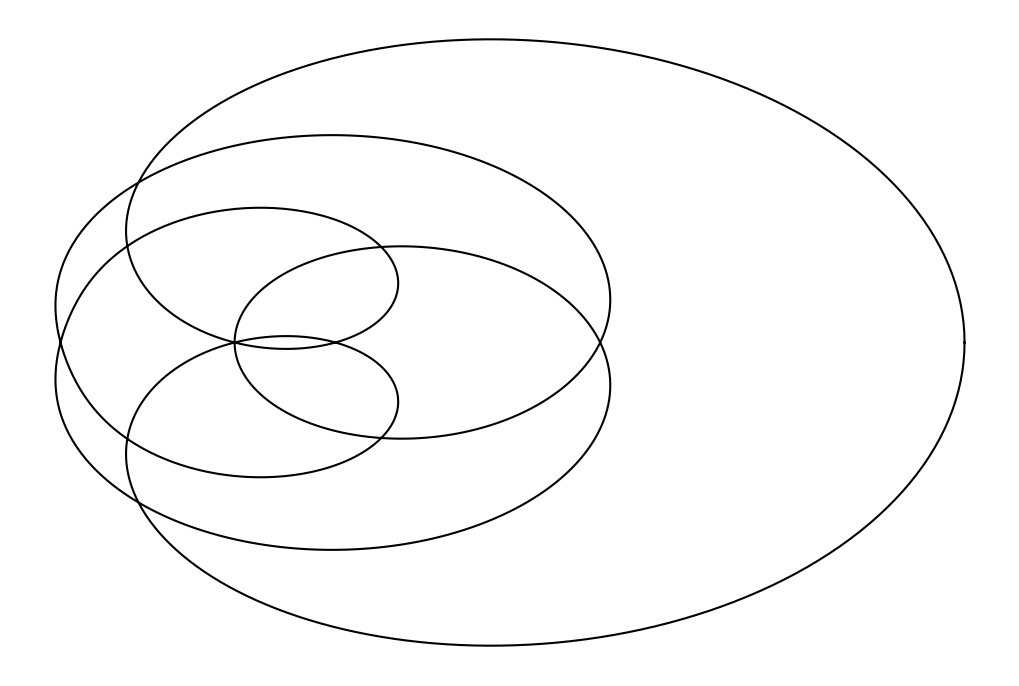

In [133]:
viz_audio(AUDIO_PATH, IMG_PATH, OUTPUT_PATH)